In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from transformers import RobertaTokenizer, RobertaModel
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
import time
import os

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed);

# Saves all plots as images. Need to create img/ folder in root directory for this to work properly
SAVE_PLOTS_AS_IMAGES = 1

# Filter test data so only test values without omitted values are included in X_te, y_te
FILTER_TEST_DATA = 1

# Limit the sizes of train/test dataset so code can run quickly when testing
LIMIT_TRAIN_DATA = 0
LIMIT_TEST_DATA = 0

subset_fraction = 0.2 # fraction for limiting train data

#NOTES:
'''
Implement GridSearchCV or RandomizedSearchCV for cross-validation during training
'''

C:\Users\micah\miniconda3\envs\cs178\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\nImplement GridSearchCV or RandomizedSearchCV for cross-validation during training\n'

# Data Preprocessing
Import and transform data so it's ready for model training/evaluation

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [3]:
labels = test_labels.columns[1:]
X, y = train['comment_text'], train[labels].values


if LIMIT_TRAIN_DATA:
    X = X[:int(len(X_tr)*subset_fraction)]
    y = y[:int(len(y_tr)*subset_fraction)]

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)
X_te, y_te = test['comment_text'], test_labels[labels].values

def remove_omitted_vals(X_te, y_te):
    mask = (y_te != -1).any(axis=1)
    X_te = X_te[mask]
    y_te = y_te[mask]
    return (X_te, y_te)
def limit_small_test_dataset(X_te, y_te):
    return (X_te[:1000], y_te[:1000])

func_list = []
if FILTER_TEST_DATA:
    func_list.append(remove_omitted_vals)
if LIMIT_TEST_DATA:
    func_list.append(limit_small_test_dataset)

X_te, y_te = reduce(lambda vals, func: func(*vals), func_list, (X_te, y_te))

print(f'''
X_tr: {X_tr.shape}, y_tr: {y_tr.shape}
X_val: {X_val.shape}, y_val: {y_val.shape}
X_te: {X_te.shape}, y_te: {y_te.shape}
''')


X_tr: (143613,), y_tr: (143613, 6)
X_val: (15958,), y_val: (15958, 6)
X_te: (63978,), y_te: (63978, 6)



# Model Training
This part needs to be reworked
Currently thinking of Transformer -> Logistic Regression model emsembled??

In [4]:
# Load RoBERTa model + tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta = RobertaModel.from_pretrained("roberta-base").to(device)
roberta.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [5]:

tic = time.time()

# Function: Encode text batch → RoBERTa embeddings

@torch.no_grad()
def roberta_encode(text_list):
    """
    Returns a numpy matrix of embeddings (CLS pooled output).
    """
    print("tokenizing")
    
    tokens = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)
    
    outputs = roberta(**tokens)
    
    # Use pooled CLS embedding: last_hidden_state[:,0,:]
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    
    return embeddings

# Get RoBERTa embeddings
X_tr_list = X_tr.tolist()
X_va_list = X_val.tolist()
print("encoding train.")
print(f'Total elapsed time: {time.time()-tic}')
X_tr_rob = roberta_encode(X_tr_list[:2000])
print("encoding validation.")
print(f'Total elapsed time: {time.time()-tic}')
X_va_rob = roberta_encode(X_va_list[:2000])
print("Done encoding.")
print(f'Total elapsed time: {time.time()-tic}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


encoding train.
Total elapsed time: 1.493312120437622
tokenizing
encoding validation.
Total elapsed time: 222.50959014892578
tokenizing
Done encoding.
Total elapsed time: 435.6766564846039


In [11]:
tic = time.time()

X_tr_rob_temp = X_tr_rob[:1000]
y_tr_temp = y_tr[:1000]
X_va_rob_temp = X_va_rob[:1000]
y_va_temp = y_val[:1000]


# Train a few ensembles of Logistic Regression models
n_models = range(1,42, 5)
models = []
model_no = 0
for n_model in n_models:
    curr_model = []
    for i in range(n_model):
        print("training begun for model: " + str(i+1))
        print(f'Total elapsed time: {time.time()-tic}')
        # Bootstrap sample
        X_sample, y_sample = resample(X_tr_rob_temp, y_tr_temp, replace=True)
    
        clf = OneVsRestClassifier(
            LogisticRegression(
                max_iter=2000,
                class_weight='balanced',
                C=1,
                random_state=seed
            )
        )
        clf.fit(X_sample, y_sample)  # y_sample shape: (n_samples, n_labels)
    
        curr_model.append(clf)
    
    print(f"Trained {len(models)} logistic regression models.")
    models.append(curr_model)
    print()
    
print("Finished.")

training begun for model: 1
Total elapsed time: 0.001009225845336914
Trained 0 logistic regression models.

training begun for model: 1
Total elapsed time: 0.9419918060302734
training begun for model: 2
Total elapsed time: 1.7854671478271484
training begun for model: 3
Total elapsed time: 2.4450693130493164
training begun for model: 4
Total elapsed time: 3.1256422996520996
training begun for model: 5
Total elapsed time: 3.697863817214966
training begun for model: 6
Total elapsed time: 4.310837507247925
Trained 1 logistic regression models.

training begun for model: 1
Total elapsed time: 4.977451324462891
training begun for model: 2
Total elapsed time: 5.688380002975464
training begun for model: 3
Total elapsed time: 6.694145441055298
training begun for model: 4
Total elapsed time: 7.322155714035034
training begun for model: 5
Total elapsed time: 7.960964202880859
training begun for model: 6
Total elapsed time: 8.426344156265259
training begun for model: 7
Total elapsed time: 9.0806887

C:\Users\micah\miniconda3\envs\cs178\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


training begun for model: 2
Total elapsed time: 27.18839693069458
training begun for model: 3
Total elapsed time: 28.12664270401001
training begun for model: 4
Total elapsed time: 28.894393920898438
training begun for model: 5
Total elapsed time: 29.832189559936523
training begun for model: 6
Total elapsed time: 31.15621829032898
training begun for model: 7
Total elapsed time: 32.293129205703735
training begun for model: 8
Total elapsed time: 33.19208550453186
training begun for model: 9
Total elapsed time: 33.844619274139404
training begun for model: 10
Total elapsed time: 34.774770736694336
training begun for model: 11
Total elapsed time: 35.877259731292725
training begun for model: 12
Total elapsed time: 37.033753633499146
training begun for model: 13
Total elapsed time: 38.257362365722656
training begun for model: 14
Total elapsed time: 39.23537015914917
training begun for model: 15
Total elapsed time: 40.463112115859985
training begun for model: 16
Total elapsed time: 41.388831615

C:\Users\micah\miniconda3\envs\cs178\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


training begun for model: 18
Total elapsed time: 57.77873229980469
training begun for model: 19
Total elapsed time: 58.351335287094116
training begun for model: 20
Total elapsed time: 59.0522985458374
training begun for model: 21
Total elapsed time: 59.776832818984985
training begun for model: 22
Total elapsed time: 60.57370400428772
training begun for model: 23
Total elapsed time: 61.10023212432861
training begun for model: 24
Total elapsed time: 61.93977355957031
training begun for model: 25
Total elapsed time: 62.751993894577026
training begun for model: 26
Total elapsed time: 63.45131993293762
Trained 5 logistic regression models.

training begun for model: 1
Total elapsed time: 64.05576992034912
training begun for model: 2
Total elapsed time: 64.60240650177002
training begun for model: 3
Total elapsed time: 65.43811345100403
training begun for model: 4
Total elapsed time: 66.07181692123413
training begun for model: 5
Total elapsed time: 67.00341892242432
training begun for model: 

C:\Users\micah\miniconda3\envs\cs178\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


training begun for model: 31
Total elapsed time: 138.96003246307373
training begun for model: 32
Total elapsed time: 139.49630880355835
training begun for model: 33
Total elapsed time: 140.04351258277893
training begun for model: 34
Total elapsed time: 140.96640133857727
training begun for model: 35
Total elapsed time: 141.88719868659973
training begun for model: 36
Total elapsed time: 142.68403935432434
training begun for model: 37
Total elapsed time: 143.41059064865112
training begun for model: 38
Total elapsed time: 143.89517450332642
training begun for model: 39
Total elapsed time: 144.76353216171265
training begun for model: 40
Total elapsed time: 145.52262425422668
training begun for model: 41
Total elapsed time: 146.20260214805603
Trained 8 logistic regression models.

Finished.


In [12]:
# Ensemble prediction (soft voting)
def ensemble_predict_proba(X, index):
    probs = np.zeros((X.shape[0], 6))
    for clf in models[index]:
        probs += clf.predict_proba(X)
    probs /= len(models)
    return probs

def ensemble_predict(X, index, threshold=0.6):
    probs = ensemble_predict_proba(X, index)  # shape (N, L)
    return (probs >= threshold).astype(int)

for i in range(len(models)):
    pred = ensemble_predict(X_va_rob_temp, i)
    f1_macro = f1_score(y_va_temp, pred, average='macro')
    f1_micro = f1_score(y_va_temp, pred, average='micro')
    print(f'Ensemble of: {n_models[i]}')
    print(f'Macro F1: {f1_macro:.4f}')
    print(f'Micro F1: {f1_micro:.4f}')

Ensemble of: 1
Macro F1: 0.0000
Micro F1: 0.0000
Ensemble of: 6
Macro F1: 0.2232
Micro F1: 0.3217
Ensemble of: 11
Macro F1: 0.3396
Micro F1: 0.5083
Ensemble of: 16
Macro F1: 0.2740
Micro F1: 0.3960
Ensemble of: 21
Macro F1: 0.2172
Micro F1: 0.3005
Ensemble of: 26
Macro F1: 0.1728
Micro F1: 0.2381
Ensemble of: 31
Macro F1: 0.1531
Micro F1: 0.2078
Ensemble of: 36
Macro F1: 0.1312
Micro F1: 0.1807
Ensemble of: 41
Macro F1: 0.1166
Micro F1: 0.1588


In [5]:
import tempfile
def atomic_save(array, path):
    # Write to a temporary file first
    dir = os.path.dirname(path)
    with tempfile.NamedTemporaryFile(delete=False, dir=dir) as tmp:
        np.save(tmp, array)
        temp_name = tmp.name
    # Atomically replace the old file
    os.replace(temp_name, path)

def roberta_encode_batch(text_list, batch_size=1000, save_path="embeds.npy"):
    # Try to load checkpoint safely
    if os.path.exists(save_path):
        try:
            print("Loading checkpoint:", save_path)
            saved_embeds = np.load(save_path)
            start = saved_embeds.shape[0]
            embeddings = [saved_embeds]
        except Exception as e:
            print("Checkpoint file corrupted, starting fresh:", e)
            start = 0
            embeddings = []
    else:
        start = 0
        embeddings = []

    total = len(text_list)

    for i in range(start, total, batch_size):
        batch = text_list[i:i+batch_size]

        with torch.no_grad():
            tokens = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)

            outputs = roberta(**tokens)
            batch_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        embeddings.append(batch_embeds)

        # SAFE SAVE
        atomic_save(np.vstack(embeddings), save_path)

        print(f"Saved batch up to index {i}")

    return np.vstack(embeddings)

In [6]:
tic = time.time()
X_tr_list = X_tr.tolist()
# train on training data
print("encoding train.")
print(f'Total elapsed time: {time.time()-tic}')
X_tr_rob = roberta_encode_batch(X_tr_list)
print("done encoding.")
print(f'Total elapsed time: {time.time()-tic}')

encoding train.
Total elapsed time: 0.006103038787841797
Loading checkpoint: embeds.npy
Saved batch up to index 81000
Saved batch up to index 82000
Saved batch up to index 83000
Saved batch up to index 84000
Saved batch up to index 85000
Saved batch up to index 86000
Saved batch up to index 87000
Saved batch up to index 88000
Saved batch up to index 89000
Saved batch up to index 90000
Saved batch up to index 91000
Saved batch up to index 92000
Saved batch up to index 93000
Saved batch up to index 94000
Saved batch up to index 95000
Saved batch up to index 96000
Saved batch up to index 97000
Saved batch up to index 98000
Saved batch up to index 99000
Saved batch up to index 100000
Saved batch up to index 101000
Saved batch up to index 102000
Saved batch up to index 103000
Saved batch up to index 104000
Saved batch up to index 105000
Saved batch up to index 106000
Saved batch up to index 107000
Saved batch up to index 108000
Saved batch up to index 109000
Saved batch up to index 110000
S

In [8]:
log_reg_ensemble = []
for i in range(11):
        print("training begun for ensemble model " + str(i+1))
        # Bootstrap sample
        X_sample, y_sample = resample(X_tr_rob, y_tr, replace=True)
    
        clf = OneVsRestClassifier(
            LogisticRegression(
                max_iter=2000,
                class_weight='balanced',
                C=1,
                random_state=seed
            )
        )
        clf.fit(X_sample, y_sample)  # y_sample shape: (n_samples, n_labels)
    
        log_reg_ensemble.append(clf)
        
print(log_reg_ensemble[0])

training begun for ensemble model 1
training begun for ensemble model 2
training begun for ensemble model 3
training begun for ensemble model 4
training begun for ensemble model 5
training begun for ensemble model 6
training begun for ensemble model 7
training begun for ensemble model 8
training begun for ensemble model 9
training begun for ensemble model 10
training begun for ensemble model 11
OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                 max_iter=2000,
                                                 random_state=1234))


In [15]:
def ensemble_predict_proba_log_reg(X):
    probs = np.zeros((X.shape[0], 6))
    for clf in log_reg_ensemble:
        probs += clf.predict_proba(X)
    probs /= len(log_reg_ensemble)
    return probs

def ensemble_predict_log_reg(X, threshold):
    probs = ensemble_predict_proba_log_reg(X)  # shape (N, L)
    return (probs >= threshold).astype(int)

def ensemble_predict_log_reg_vector(X, thresholds):
    """
    thresholds: shape (L,) or list of length L
    """
    probs = ensemble_predict_proba_log_reg(X)  # (N, L)
    thresholds = np.asarray(thresholds)        # (L,)
    return (probs >= thresholds).astype(int)


# Model Evaluation
Generate statistics and graphs to visualize model performance.
This part also needs to be redone

In [7]:
X_te_list = X_te.tolist()
print("encoding test.")
print(f'Total elapsed time: {time.time()-tic}')
X_te_rob = roberta_encode_batch(X_te_list, save_path="embeds_test.npy")
print("encoding test done.")
print(f'Total elapsed time: {time.time()-tic}')

encoding test.
Total elapsed time: 9321.548095941544
Loading checkpoint: embeds_test.npy
Checkpoint file corrupted, starting fresh: No data left in file
Saved batch up to index 0
Saved batch up to index 1000
Saved batch up to index 2000
Saved batch up to index 3000
Saved batch up to index 4000
Saved batch up to index 5000
Saved batch up to index 6000
Saved batch up to index 7000
Saved batch up to index 8000
Saved batch up to index 9000
Saved batch up to index 10000
Saved batch up to index 11000
Saved batch up to index 12000
Saved batch up to index 13000
Saved batch up to index 14000
Saved batch up to index 15000
Saved batch up to index 16000
Saved batch up to index 17000
Saved batch up to index 18000
Saved batch up to index 19000
Saved batch up to index 20000
Saved batch up to index 21000
Saved batch up to index 22000
Saved batch up to index 23000
Saved batch up to index 24000
Saved batch up to index 25000
Saved batch up to index 26000
Saved batch up to index 27000
Saved batch up to in

In [23]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
preds = []
micros = []
macros = []
hammings = []
for th in thresholds:
    pred = ensemble_predict_log_reg(X_te_rob, th)
    preds.append(pred)
    f1_macro = f1_score(y_te, pred, average='macro')
    macros.append(f1_macro)
    f1_micro = f1_score(y_te, pred, average='micro')
    micros.append(f1_micro)
    hamming_acc = 1 - hamming_loss(y_te, pred)
    hammings.append(hamming_acc)
    print(f'Threshold of: {th}')
    print(f'Macro F1: {f1_macro:.4f}')
    print(f'Micro F1: {f1_micro:.4f}')
    print(f'Hamming Accuracy: {hamming_acc:.4f}')
    print()

Threshold of: 0.1
Macro F1: 0.1903
Micro F1: 0.2456
Hamming Accuracy: 0.7724

Threshold of: 0.2
Macro F1: 0.2398
Micro F1: 0.3111
Hamming Accuracy: 0.8394

Threshold of: 0.3
Macro F1: 0.2750
Micro F1: 0.3571
Hamming Accuracy: 0.8732

Threshold of: 0.4
Macro F1: 0.3073
Micro F1: 0.3983
Hamming Accuracy: 0.8967

Threshold of: 0.5
Macro F1: 0.3366
Micro F1: 0.4343
Hamming Accuracy: 0.9142

Threshold of: 0.65
Macro F1: 0.3818
Micro F1: 0.4857
Hamming Accuracy: 0.9350

Threshold of: 0.7
Macro F1: 0.3982
Micro F1: 0.5034
Hamming Accuracy: 0.9412

Threshold of: 0.75
Macro F1: 0.4162
Micro F1: 0.5201
Hamming Accuracy: 0.9471

Threshold of: 0.8
Macro F1: 0.4355
Micro F1: 0.5374
Hamming Accuracy: 0.9529

Threshold of: 0.85
Macro F1: 0.4517
Micro F1: 0.5499
Hamming Accuracy: 0.9581

Threshold of: 0.9
Macro F1: 0.4696
Micro F1: 0.5608
Hamming Accuracy: 0.9635

Threshold of: 0.93
Macro F1: 0.4798
Micro F1: 0.5622
Hamming Accuracy: 0.9667

Threshold of: 0.94
Macro F1: 0.4826
Micro F1: 0.5597
Hamming

In [21]:
ensemble_thresholds = (0.87, 0.85, 0.9, 0.9, 0.9, 0.9)
pred = ensemble_predict_log_reg_vector(X_te_rob, ensemble_thresholds)

f1_macro = f1_score(y_te, pred, average='macro')

f1_micro = f1_score(y_te, pred, average='micro')

hamming_acc = 1 - hamming_loss(y_te, pred)

print(f'Threshold of specific from log_reg')
print(f'Macro F1: {f1_macro:.4f}')
print(f'Micro F1: {f1_micro:.4f}')
print(f'Hamming Accuracy: {hamming_acc:.4f}')
print()

Threshold of specific from log_reg
Macro F1: 0.4645
Micro F1: 0.5574
Hamming Accuracy: 0.9620



In [18]:
'''Optimal thresholds per label: {'toxic': np.float64(0.87), 'severe_toxic': np.float64(0.85), 'obscene': np.float64(0.9), 'threat': np.float64(0.9), 'insult': np.float64(0.9), 'identity_hate': np.float64(0.9)}
toxic Accuracy: 0.9575
severe_toxic Accuracy: 0.9825
obscene Accuracy: 0.9818
threat Accuracy: 0.9936
insult Accuracy: 0.9556
identity_hate Accuracy: 0.9858'''

"Optimal thresholds per label: {'toxic': np.float64(0.87), 'severe_toxic': np.float64(0.85), 'obscene': np.float64(0.9), 'threat': np.float64(0.9), 'insult': np.float64(0.9), 'identity_hate': np.float64(0.9)}\ntoxic Accuracy: 0.9575\nsevere_toxic Accuracy: 0.9825\nobscene Accuracy: 0.9818\nthreat Accuracy: 0.9936\ninsult Accuracy: 0.9556\nidentity_hate Accuracy: 0.9858"

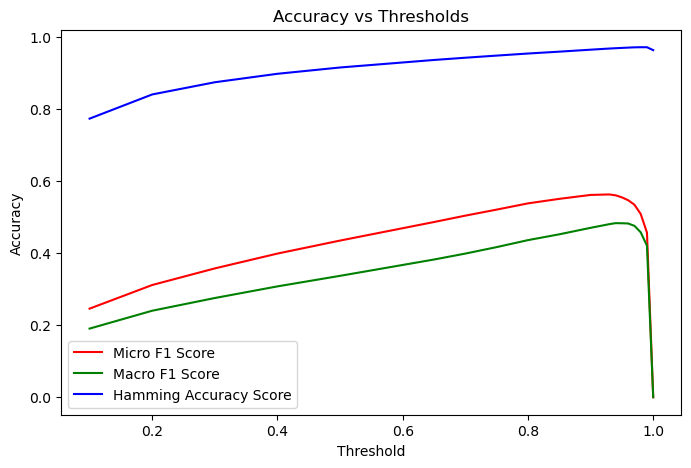

In [22]:
plt.figure(figsize=(8,5))
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Thresholds')

plt.plot(thresholds, micros, label="Micro F1 Score", color="red")
plt.plot(thresholds, macros, label="Macro F1 Score", color="green")
plt.plot(thresholds, hammings, label="Hamming Accuracy Score", color="blue")

plt.legend()
plt.show()

In [25]:
haccstr = '''
Threshold of: 0.98
Macro F1: 0.4572
Micro F1: 0.5082
Hamming Accuracy: 0.9703'''
print("Best hamming accuracy found: " + haccstr)

Best hamming accuracy found: 
Threshold of: 0.98
Macro F1: 0.4572
Micro F1: 0.5082
Hamming Accuracy: 0.9703


In [26]:
f1accstr = '''
Threshold of: 0.93
Macro F1: 0.4798
Micro F1: 0.5622
Hamming Accuracy: 0.9667

Threshold of: 0.94
Macro F1: 0.4826
Micro F1: 0.5597
Hamming Accuracy: 0.9676'''
print("Best f1 accuracies found: " + f1accstr)

Best f1 accuracies found: 
Threshold of: 0.93
Macro F1: 0.4798
Micro F1: 0.5622
Hamming Accuracy: 0.9667

Threshold of: 0.94
Macro F1: 0.4826
Micro F1: 0.5597
Hamming Accuracy: 0.9676
